# Exemple d'algorithmes génétiques avec un mastermind 
## Objectif :
Présenter simplement les algorithmes génétiques à l'aide d'un exemple simple, un mastermind !
Ce fichier sera le premier d'une longue série de notebooks sur les algorithmes génétiques. 
Il pourra m'aider à l'analyse des différentes techniques et à leurs cas d'utilisation.
L'objectif est pour la machine de deviner une combinaison en un minimum d'iterations. 
Moins il y a d'iterations, plus l'algorithme est performant. Dans le mastermind original, l'utilisateur a perdu s'il ne trouve pas la combinaison gagnante au bout d'un certain nombre d'iterations. 
Dans l'exemple ici, la machine ne peut pas perdre. L'objectif était de tester la robustesse des algorithmes.
## Règle du mastermind
Le mastermind se joue à 2 joueurs, sur un plateau de 4 colonnes et de 12 rangés et se joue avec des billes de 4 couleurs différentes. Le mastermind possède une combinaison secrète de 4 billes de couleurs, et l'objectif du joueur est de deviner avant la 13e tentative la combinaison secrète. 
Pour l'aider, il lui est révélé le nombre de billes posées au bon endroit et de la bonne couleur, sans lui reveler lesquelles sont correctes.
## Ce qui est présenté dans ce notebook
- La notion de fitness
- La notion de population
- La notion d'individus
- La notion de chromosomes
- La notion de genes 

## Concepts avancés dans ce notebook
- Les types de sélections    
    - Sélection par roulette    
    - Sélection par rang    
    - Sélection par tournoi    
    - Sélection aléatoire
- La notion d'élitisme
- Les types de reproduction d'individus    
    - One point Cross-over    
    - Two-point Cross-over    
    - Uniforme Cross-Over

In [1]:
# Importation des librairies utilisés
import random
import numpy as np
import matplotlib.pyplot as plt

defaultProbaPerLetter = 10
batch_size = 30

In [2]:
# Definition du plateau
class Plateau:
    def __init__(self, secret):
        self.secret = secret
        self.secretLen = len(secret);
        # Initialisation des gènes (probabilité de 10 chacun)
        self.caracteres = "azertyuiopqsdfghjklmwxcvbn0123456789_'";
        self.genesDict = []
        self.totalGenesCount = defaultProbaPerLetter*len(self.caracteres)
        # Remplissage du tableau de prédiction avec la valeur par défaut.
        for i in range (0,self.secretLen):
            self.genesDict.append({});
            for l in self.caracteres:
                self.genesDict[i][l] = defaultProbaPerLetter;
        
    def printDict(self):
        print(self.genesDict)
        
    '''
    Cette fonction sert à mémoriser les résultats générés précédemment.
    Il enregistre pour chaque case les résultats obtenus lors des précédentes tentatives.
    Cela permet à l'algorithme d'affiner lentement sa prédiction pour tendre vers la bonne solution.
    '''
    def evolveGenes(self, individu, fitness):
        if (fitness == 0):
            return;
        index = 0
        for l in individu:
            self.genesDict[index][l]+= fitness
            index+=1;
        self.totalGenesCount += fitness

Il existe aussi une méthode appelée Uniform Crossover, qui change aléatoirement les gènes, dans "paquets ou coupures"distinctes. Un exemple avec les deux parents ----- et +++++ peut donner -+-+-. 
__Cet exemple n'est pas encore implémenté dans l'algorithme.__
<hr>
Voici la definition du joueur.

In [3]:
# Définition du joueur. 
# Il va jouer un coup, et le changer (muter) pour chercher une meilleure combinaison.
class Joueur:
    def __init__(self, plateau):
        self.p = plateau;
        self.crossoverOne = True;
        
    # Generation d'un individu aléatoire.
    def generateRandomPlay(self):
        individu = "";
        for i in range(0,self.p.secretLen):
            lettre = p.caracteres[random.randint(0, len(p.caracteres)-1)];
            individu += lettre
        return individu;
    
    # Génération d'un individu dont les gènes sont probabilisés par les résultats précédents
    def generatePlay(self):
        individu = "";
        for i in range(0,self.p.secretLen):
            letterIndex = random.randint(0, p.totalGenesCount)
            for l in p.genesDict[i]:
                if (letterIndex - int(p.genesDict[i][l]) <= 0):
                    individu+=l
                    break
                else:
                    letterIndex -= p.genesDict[i][l]
        return individu;
    
    # Génération d'une population de 10 individus (par défaut) avec des gènes aléatoires.
    def generatePopulation(self):
        pop = [];
        for i in range(0,batch_size):
            play = self.generateRandomPlay();
            pop.append(play);
        return pop;
    
    '''
    Cette fonction génère des enfants qui possèdent une partie des gènes de son parent.
    la génération des gènes des enfants est générée par un One-point Cross-over, ou un Two-point Cross-over.
    Le principe de mutation n'est pas introduit ici.
    Il a pour principe de changer au hasard un gène sans tenir compte de la probabilité.
    Les mutations doivent être rares, et permettent de limiter la convergence de l'algorithme.
    '''
    def generatePopulationFromParent(self, parent):
        pop = [];
        for i in range(0,batch_size):
            play = self.generatePlay();
            if (self.crossoverOne):
                play = self.onePointCrossover(play);
            else:
                play = self.twoPointCrossover(play);
            pop.append(play);
        return pop;
        
    '''
    La fitness est la valeur utilisée par l'algorithme pour estimer ou noter le résultat d'un individu
    sur l'objectif à atteindre. Dans notre cas, chaque lettre correctement placée compte comme 1 point.
    La fitness maximale est donc la taille du mot secret !
    '''
    def getFitness(self, individu):
        fitness = 0;
        for i in range(0,self.p.secretLen):
            if(self.p.secret[i] == individu[i]):
                fitness += 1;
        return fitness;
    
    # Retourne l'index dans la population de l’élément avec la meilleure concordance.
    # (la plus haute concordance avec le mot secret)
    def getFittestIndex(self, population):
        index = 0
        fittest = self.getFitness(population[index])
        for i in range(0,len(population)):
            fit = self.getFitness(population[i])
            if (fittest < fit):
                index = i;
                fittest = fit;
        return index;
    
    ''' 
    Le one-point cross-over est une méthode de génération d'enfants.
    Admettons un parent avec le chromosome (ensemble de gènes) suivant : '-----'
    Et admettons un individu généré avec les gènes suivants : '+++++'
    Le one-point cross-over va générer l'enfant des deux parents en prenant 
    un index aléatoirement, puis en mélangeant les gènes du premier parent avec le second sur cet index.
    Exemple avec l'index 2, l'enfant des deux parents ci-dessus donne :'--+++'..
    '''
    def onePointCrossover(self, individu):
        side = random.randint(0, 1)
        i = random.randint(1,self.p.secretLen-1)
        play = self.generateRandomPlay()
        if (side == 0):
            ret = individu[:i] + play[:self.p.secretLen-i]
        else:
            ret = play[:i] + individu[i-self.p.secretLen:] 
        return ret;
        
    '''
    Le two-point cross-over sert également à mélanger les genes de deux parents,
    mais cette fois-ci avec deux index.
    Donc pour les mêmes parents ----- et +++++ avec les index 2 et 4, l'enfant donnera :'--++-'.
    '''
    def twoPointCrossover(self, individu):
        i = random.randint(0,self.p.secretLen-1)
        size = random.randint(1,self.p.secretLen-i)
        play = self.generateRandomPlay()
        ret = individu[0:i] + play[i:i+size] + individu[i+size:self.p.secretLen]
        return ret;

In [4]:
# Initialisation du jeu
# Définir 5 combinaisons de 38 possibilités correspond à une chance sur 79.2 millions de tomber sur la bonne.
p = Plateau("wha0u");
j = Joueur(p);


Ici, nous allons sélectionner le meilleur parent, et le faire se reproduire pour former la prochaine génération. C'est à mon sens la meilleure solution dans ce cas, car il n'existe qu'une seule solution, qui est accessible via un seul chemin. Réduire le nombre de parents permet donc de converger plus rapidement vers la meilleure solution.

Voici l'algorithme principal de la résolution du mastermind. un bref résumé de l'algorithme donne :
- Création d'une population aléatoire
- Calcul de la fitness de la population, et récupération du meilleur individu
- Jusqu'à ce que la solution soit trouvée, faire :
    - Célectionner un parent depuis la population;
    - Appliquer un cross-over et générer une nouvelle population
    - Calculer la fitness de la nouvelle population

In [5]:
# Algorithme principal :
# création d'une population de 10 individus pour le démarrage :
pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness));
p.evolveGenes(pop[fittestIndex], fitness)
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness));
    i+=1;

print("!! Trouvé !! - "+ pop[fittestIndex]+"  //  tentatives : "+str(i))

tm'0w   --fitness : 1
oha9r   --fitness : 2
7hyuo   --fitness : 1
9hpyu   --fitness : 2
ipvju   --fitness : 1
wqkcs   --fitness : 1
stajf   --fitness : 1
a4w0u   --fitness : 2
2kh0t   --fitness : 1
eh8e6   --fitness : 1
wnmqa   --fitness : 1
8maav   --fitness : 1
2zavc   --fitness : 1
9hn5d   --fitness : 1
yhktu   --fitness : 2
n9a04   --fitness : 2
kvi08   --fitness : 1
s_a09   --fitness : 2
haa55   --fitness : 1
w8ayq   --fitness : 2
6hhw_   --fitness : 1
egn8u   --fitness : 1
8q8nu   --fitness : 1
mh2ov   --fitness : 1
ylu0q   --fitness : 1
rhajl   --fitness : 2
3iatu   --fitness : 2
nieku   --fitness : 1
wha2j   --fitness : 3
liac8   --fitness : 1
3280z   --fitness : 1
w75gu   --fitness : 2
whpo5   --fitness : 2
eh_0i   --fitness : 2
xk1'u   --fitness : 1
khau7   --fitness : 2
wxjxu   --fitness : 2
m280u   --fitness : 2
a93bu   --fitness : 1
_ra0w   --fitness : 2
1jx0l   --fitness : 1
s4405   --fitness : 1
mh6jn   --fitness : 1
ohade   --fitness : 2
tke0u   --fitness : 2
6c90m   --

Dans l'algorithme principal ci-dessus, la sélection du parent se fait simplement par le fait que le meilleur l'emporte. Cependant il existe plusieurs autres types de sélection de parents.
Nous allons en voir quelques exemples en dessous.
<hr> 

# la sélection par roulette
Le principe est simple. Les individus avec le plus de fitness ont plus de chances d’être gardés pour la prochaine production de la population. illustration simple en images :

<img src="https://www.researchgate.net/profile/Manfred_Breit/publication/237507026/figure/fig7/AS:298797780488200@1448250350801/Roulette-wheel-selection-using-fitness-weighted-probability.png" alt="roulette wheel selection;">

[Source de l'image](https://www.researchgate.net/figure/Roulette-wheel-selection-using-fitness-weighted-probability_fig7_237507026)

Voici un algorithme pour le mettre en place :

In [6]:
pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness));
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex;
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness));
    i+=1;
    # Calcul du total de la fitness: 
    totalFitness = 0
    for J in range(0,len(pop)):
        totalFitness += j.getFitness(pop[J])
    # Nombre aléatoire entier entre 0 et totalFirness :
    indexParent = random.randint(0,totalFitness);
    # Trouver l'index de l'individu à garder :
    parentIndex = 0
    for J in range(0,len(pop)):
        if (totalFitness <= 0):
            parentIndex = J;
            break;
        totalFitness -= j.getFitness(pop[J])

print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

o470u   --fitness : 2
wji0u   --fitness : 3
whadf   --fitness : 3
wha0d   --fitness : 4
whff9   --fitness : 2
aha0u   --fitness : 4
4ha0o   --fitness : 3
2ganu   --fitness : 2
aha0q   --fitness : 3
qya0u   --fitness : 3
cha0p   --fitness : 3
whbm2   --fitness : 2
fha0u   --fitness : 4
wha1p   --fitness : 3
z7a0u   --fitness : 3
xka0u   --fitness : 3
2ha03   --fitness : 3
1ha03   --fitness : 3
whabm   --fitness : 3
7ha0y   --fitness : 3
whap0   --fitness : 3
_ha09   --fitness : 3
88a0u   --fitness : 3
whaz3   --fitness : 3
6hahu   --fitness : 3
wh702   --fitness : 3
sha07   --fitness : 3
w6a08   --fitness : 3
2ha0i   --fitness : 3
'ia0u   --fitness : 3
wh2uu   --fitness : 3
wsaeu   --fitness : 3
whafi   --fitness : 3
vh20u   --fitness : 3
bha0u   --fitness : 4
whaaz   --fitness : 3
hla0u   --fitness : 3
wha0u   --fitness : 5
!! Trouvé !! - wha0u  //  tentatives : 38  // nombre d'individus testé : 1140


<hr>

# Sélection par rang
<img src="https://www.tutorialspoint.com/genetic_algorithms/images/rank_selection.jpg" alt="rank selection;">

[Source de l'image](https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_parent_selection.htm)

Avec cette sélection, on garde un nombre fixe d'individus issus de la population ayant la meilleure concordance. une fois ces individus en notre procession, on en sélectionne un au hasard, puis on régénère la population.

Cette méthode fonctionne avec des éléments possédants une concordance négative, mais a l’inconvénient de perdre en sélection naturelle rapidement, et ainsi donc privilégier les mauvais parents lors de la génération.

Exemple d'algorithmes ci-dessous ;

In [7]:
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # Calcul des n meilleurs individus de la population:
    n = 5
    arr = np.array([])
    for ind in range(0,len(pop)):
        arr = np.append(arr,j.getFitness(pop[ind]))
    # Récupération des meilleurs index du tableau
    sortedArr = (-arr).argsort()[:n]
    # Choix du prochain parent
    parentIndex = sortedArr[random.randint(0,n-1)]

print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

trw0z   --fitness : 1
wxa0t   --fitness : 3
ihadu   --fitness : 3
1_alu   --fitness : 2
whl05   --fitness : 3
wha05   --fitness : 4
kha0u   --fitness : 4
dhaou   --fitness : 3
ghaju   --fitness : 3
kha0l   --fitness : 3
cqa0u   --fitness : 3
5ha0y   --fitness : 3
8ha0l   --fitness : 3
pha0u   --fitness : 4
wha0v   --fitness : 4
jba0u   --fitness : 3
yha0v   --fitness : 3
kha0u   --fitness : 4
k2a0u   --fitness : 3
dha07   --fitness : 3
whr07   --fitness : 3
wha04   --fitness : 4
wha0n   --fitness : 4
whyth   --fitness : 2
wxanv   --fitness : 2
o5awu   --fitness : 2
thatu   --fitness : 3
0haxu   --fitness : 3
wha3u   --fitness : 4
1haiu   --fitness : 3
wxa0b   --fitness : 3
whax1   --fitness : 3
'za0u   --fitness : 3
8hg0u   --fitness : 3
lha0u   --fitness : 4
0xa0u   --fitness : 3
4ha0a   --fitness : 3
'ha0u   --fitness : 4
ghi0u   --fitness : 3
nha05   --fitness : 3
woa0y   --fitness : 3
dhamu   --fitness : 3
wh80i   --fitness : 3
bca0u   --fitness : 3
whx0u   --fitness : 4
wha0c   --

<hr>

# Sélection par tournoi
<img src="https://www.tutorialspoint.com/genetic_algorithms/images/tournament_selection.jpg" alt="tournement selection;">
Avec cette sélection, On sélectionne n nombre d'individus, puis on les fait "se battre" entre eux, de sorte à tirer les meilleurs.

Un exemple d'algorithme ci dessous :

In [8]:
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # Sélection des n maximums challengers de la population:
    n = 5
    arr = []
    indArr = []
    for ind in range (0,n):
        x = random.randint(0,batch_size-1)
        arr.append(j.getFitness(pop[x]))
        indArr.append(x)
    
    # Récupération de l'index du parent
    winnerIndex = arr.index(max(arr))
    parentIndex = indArr[winnerIndex]
    
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

n4uvu   --fitness : 1
2ha0x   --fitness : 3
hha0c   --fitness : 3
fha03   --fitness : 3
wyq0u   --fitness : 3
wra0f   --fitness : 3
ahaa8   --fitness : 2
sha03   --fitness : 3
whai1   --fitness : 3
eha0u   --fitness : 4
hhatu   --fitness : 3
whaev   --fitness : 3
'ha06   --fitness : 3
hfa0u   --fitness : 3
whagr   --fitness : 3
weh0u   --fitness : 3
whahl   --fitness : 3
0ha0u   --fitness : 4
sha0k   --fitness : 3
kha0u   --fitness : 4
kha07   --fitness : 3
l_a0u   --fitness : 3
sha0u   --fitness : 4
w5a03   --fitness : 3
6ha0t   --fitness : 3
lha0u   --fitness : 4
whagy   --fitness : 3
'ha0u   --fitness : 4
qhr0b   --fitness : 2
w'a0o   --fitness : 3
wha0v   --fitness : 4
3ha0f   --fitness : 3
wpa0f   --fitness : 3
0ha03   --fitness : 3
cha0m   --fitness : 3
pxa0u   --fitness : 3
6ha0u   --fitness : 4
whdhu   --fitness : 3
wha03   --fitness : 4
ws50u   --fitness : 3
'ha0u   --fitness : 4
wma0b   --fitness : 3
xka05   --fitness : 2
5ha6u   --fitness : 3
whaz_   --fitness : 3
lia0u   --

<hr>

# Sélection aléatoire
Avec cette sélection, On choisit un individu aléatoirement, pour qu'il devienne le parent de la prochaine sélection.

Cette méthode de sélection est rarement utilisée, car elle apporte peu d'avantages à l'algorithme et amène souvent l'algorithme à s'écarter du bon chemin.

Exemple d'algorithmes ci-dessous ;

In [9]:
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # Sélection du parent de la population:
    parentIndex = random.randint(0,len(pop)-1)
    
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

wq'a1   --fitness : 1
wha0e   --fitness : 4
wha0'   --fitness : 4
sha0u   --fitness : 4
wha0a   --fitness : 4
wqa0p   --fitness : 3
wha0e   --fitness : 4
yha0q   --fitness : 3
vka0u   --fitness : 3
whazc   --fitness : 3
sha4u   --fitness : 3
iha01   --fitness : 3
whj0d   --fitness : 3
xha0t   --fitness : 3
wha0n   --fitness : 4
4hx0u   --fitness : 3
gha0g   --fitness : 3
iha0l   --fitness : 3
whahw   --fitness : 3
wga0u   --fitness : 4
jhayu   --fitness : 3
'ha0u   --fitness : 4
6ha5u   --fitness : 3
jha0t   --fitness : 3
0ba0u   --fitness : 3
whaiz   --fitness : 3
bh'0u   --fitness : 3
aha0u   --fitness : 4
eoa0u   --fitness : 3
woa03   --fitness : 3
fha0j   --fitness : 3
fca0u   --fitness : 3
wra0q   --fitness : 3
whapy   --fitness : 3
whk8a   --fitness : 2
s2a0u   --fitness : 3
whe0z   --fitness : 3
xhh0u   --fitness : 3
08a0u   --fitness : 3
wha0x   --fitness : 4
7ha0c   --fitness : 3
xhals   --fitness : 2
ihaxu   --fitness : 3
sda0u   --fitness : 3
8ha0u   --fitness : 4
3ha0i   --

<hr>

# Affichage avec des graphes
## Exemple de base de l'exercice :

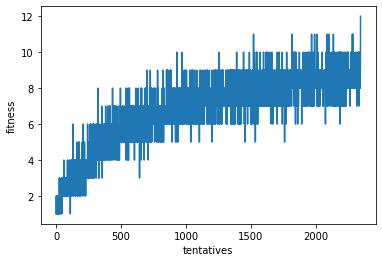

!! Trouvé !! - awes0me_p4ss  //  tentatives : 2346  // nombre d'individus testé : 70380


In [10]:
p = Plateau("awes0me_p4ss"); #38¹²   ~ 9e⁺¹⁸ possibilités
j = Joueur(p);

pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
p.evolveGenes(pop[fittestIndex], fitness)
fitnessArray = []
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    fitnessArray.append(fitness)
    p.evolveGenes(pop[fittestIndex], fitness)
    i+=1;


plt.plot(fitnessArray)
plt.ylabel('fitness')
plt.xlabel('tentatives')
plt.show()
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

<hr>

## notion d’élitisme

L’élitisme est simplement le fait d’insérer le meilleur individu dans la prochaine itération. cela permet d’empêcher la régression de la fitness d'une tentative à l'autre.

Cela permet d'avoir une progression constante, sans régressions.

Sur le même exemple :

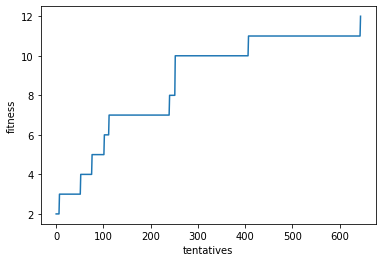

!! Trouvé !! - awes0me_p4ss  //  tentatives : 646  // nombre d'individus testé : 19380


In [11]:
p = Plateau("awes0me_p4ss"); #38¹²   ~ 9e⁺¹⁸ possibilités
j = Joueur(p);

pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
p.evolveGenes(pop[fittestIndex], fitness)
fitnessArray = []
i=1;
while (fitness < p.secretLen):
    fittestIndividual = pop[fittestIndex]
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    pop.append(fittestIndividual) #ajout de l'elite ici
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    fitnessArray.append(fitness)
    p.evolveGenes(pop[fittestIndex], fitness)
    i+=1;


plt.plot(fitnessArray)
plt.ylabel('fitness')
plt.xlabel('tentatives')
plt.show()
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))